# Fine tuning T5 on XSum with Truncation of Tokens

Pruning head and tail of sentences to see if accuracy is affected

Reference: [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)

1. **head-only**: keep the first 510 tokens6
2. **tail-only**: keep the last 510 tokens
3. **head+tail**: empirically select the first 128
and the last 382 tokens.

Sections

1. #### [Baseline Training with T5 and Xsum](#1)
2. #### [Truncating middle tokens with T5 and Xsum](#2)
3. #### [Plotting Loss](#3)
3. #### [Draft](#4)

#### To do:
* [x] Check if the truncation does happen
* [x] Not count the padding (0's in the array)
* [x] Fix rouge score implementation
* [x] Fix predictions vs actuals results display
* [ ] Implement the same setup as the paper
* [ ] Do something different/additional to the paper

<a id="1"></a>
# 1. Baseline Training with T5 and Xsum


In [1]:
# !pip3 install datasets
# !pip3 install rich
# !pip3 install SentencePiece
# !pip3 install rouge_score

In [2]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

# Importing the T5 modules from huggingface/transformers
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration, tokenization_utils_base

import nltk

from datasets import load_dataset
from datasets import load_metric

#uncomment this if you are not using puffer
# import os
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# !pip3 install datasets
# !pip3 install rich
# !pip3 install SentencePiece
# !pip3 install rouge_score

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
print("Done")

Done


## Dataset Class

In [4]:
from torch.utils.data import Dataset
import torch
import pandas as pd

class Dataset(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, data, tokenizer, model_name, source_len, target_len, source_text, target_text, #train = True,
    ):
        """
        Initializes a Dataset class

        Args:yo
            data: Input data
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_len = source_len
        self.summ_len = target_len
        
        # Xsum contains about 200000+ samples, so lets just take a small portion
        self.source_text = self.data[source_text][:1000]
        if "t5" in model_name:
            self.source_text = self.add_prefix(self.source_text)
        self.target_text = self.data[target_text][1:1000]

    def __len__(self):
        """returns the length of data"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }
    
    def add_prefix(self, examples):
        prefix = "summarize: "
        inputs = [prefix + doc for doc in examples]
        return inputs

## Train Function

In [5]:
def train(epoch, tokenizer, model, device, loader, optimizer, scheduler):
    
    """
    Function to be called for training with the parameters passed from main function

    """

    model.train()
    losses = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        if _ % 10 == 0:
            print("STEP: ", _,"/",len(loader))
            training_logger.add_row(str(epoch), str(f'{_}/{len(loader)}'), str(loss))
            console.print(training_logger)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.detach()

    scheduler.step()
    losses = losses/len(loader)
    return losses

## Validation Function

In [6]:
def validate(epoch, tokenizer, model, device, loader):

    """
    Function to evaluate model for predictions

    """
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                  input_ids = ids,
                  attention_mask = mask, 
                  max_length=150, 
                  num_beams=2,
                  repetition_penalty=2.5, 
                  length_penalty=1.0, 
                  early_stopping=True
                  )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _ % 10==0:
                console.print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)

    return predictions, actuals

<hr>

## Rouge Score

In [7]:
from rouge_score import rouge_scorer

# def compute_metrics(predictions, actuals, tokenizer):
    
#     scorer = rouge_scorer.RougeScorer(['rouge1'])
    
#     # a dictionary that will contain the results
#     rouge = {'precision': [], 'recall': [], 'fmeasure': []}

#     # for each of the hypothesis and reference documents pair
#     for (p, a) in zip(predictions, actuals):
#         # computing the ROUGE
#         score = scorer.score(p, a)
#         # separating the measurements
#         precision, recall, fmeasure = score['rouge1']
#         # add them to the proper list in the dictionary
#         rouge['precision'].append(precision)
#         rouge['recall'].append(recall)
#         rouge['fmeasure'].append(fmeasure)

#     return rouge


def compute_metrics(predictions, actuals, tokenizer):
    
    # <your code here>
    metric = load_metric("rouge")
    result = metric.compute(predictions=predictions, references=actuals, use_stemmer=True)
    
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    rouge = {k: round(v, 4) for k, v in result.items()}

    return rouge

<hr>

## Trainer Class

In [8]:
def Trainer(
    dataset, source_text, target_text, model_params, output_dir="outputs/", device = "cuda:2"
):

    """
    trainer

    """
    
    losses = []
    
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # tokenzier for encoding the text
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if "bart" in model_params["MODEL"]:
        tokenizer = BartTokenizer.from_pretrained(f'facebook/{model_params["MODEL"]}')
        model = BartForConditionalGeneration.from_pretrained(f'facebook/{model_params["MODEL"]}')
    elif "t5" in model_params["MODEL"]:
        tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
        model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    elif "pegasus" in model_params["MODEL"]:
        tokenizer = PegasusTokenizer.from_pretrained(f'google/{model_params["MODEL"]}')
        model = PegasusForConditionalGeneration.from_pretrained(f'google/{model_params["MODEL"]}')
    else:
        raise ValueError("Undefined model")
        
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Creation of Dataset and Dataloader
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    
    console.print(f"FULL Dataset: {dataset.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")
    
    del dataset
    
    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = Dataset(
        train_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = True,
    )
    val_set = Dataset(
        val_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = False,
    )
    
    del train_dataset, val_dataset
    
    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    print("TRAIN LOADER: ", len(training_loader))
    print("VAL LOADER: ", len(val_loader))
    
    del train_params, val_params
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )
    
    if model_params["SCHEDULER"] == "linear":
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    
    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):

        loss = train(epoch, tokenizer, model, device, training_loader, optimizer, scheduler)
        losses.append(loss.cpu().numpy())

        # evaluating test dataset        
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, f"""predictions_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE TO CSV FINISHED")
        
        
        rouge = compute_metrics(predictions, actuals, tokenizer)
        
        rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
        rouge_df.to_csv(os.path.join(output_dir, f"""rouge_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE ROUGE TO CSV FINISHED")
    
    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    # converting list to array
    arr = np.array(losses)
    np.save(os.path.join(output_dir, f"""losses_{model_params['MODEL']}_epoch{model_params['TRAIN_EPOCHS']}"""), arr)

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

### Loading Data

In [9]:
from torch import cuda
device = 'cuda:2' if cuda.is_available() else 'cpu'
print("configured device: ", device)

data = 'xsum'

if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")

configured device:  cuda:2


Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

## Model Params

In [10]:
# let's define model parameters specific to BART
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE": 8,  # training batch size
    "VALID_BATCH_SIZE": 8,  # validation batch size
    "TRAIN_EPOCHS": 3,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 2e-05,  # learning rate default betas=(0.9, 0.999), eps=1e-08
    "SCHEDULER": "linear",
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 36,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

print("===== Ouputs to be saved in =======")
print(os.getcwd() + '\outputs\\')

===== Ouputs to be saved in =======
/root/NLP/nlp-ablation-t5/experiments\outputs\


## Train

In [11]:
console = Console(record=True)

training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

Trainer(
    dataset=dataset,
    source_text=source_text, 
    target_text=target_text,
    model_params=model_params,
#     output_dir=os.getcwd() + '\outputs\\',
    output_dir='outputs',
    device = device,
)

[10:04:46] [Model]: Loading t5-small...                                      ]8;id=19697;file:///tmp/ipykernel_13449/1005472169.py\1005472169.py]8;;\:]8;id=858414;file:///tmp/ipykernel_13449/1005472169.py#18\18]8;;\
                                                                                             

[10:05:02] [Data]: Reading data...                                           ]8;id=680132;file:///tmp/ipykernel_13449/1005472169.py\1005472169.py]8;;\:]8;id=588418;file:///tmp/ipykernel_13449/1005472169.py#38\38]8;;\
                                                                                             

FULL Dataset: {'train': (204045, 3), 'validation': (11332, 3), 'test': (11334, 3)}

TRAIN Dataset: (204045, 3)

TEST Dataset: (11332, 3)

TRAIN LOADER:  125
VAL LOADER:  125


[10:05:03] [Initiating Fine Tuning]...                                      ]8;id=89226;file:///tmp/ipykernel_13449/1005472169.py\1005472169.py]8;;\:]8;id=999952;file:///tmp/ipykernel_13449/1005472169.py#105\105]8;;\
                                                                                             

STEP:  0 / 125


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   | 0/125 | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

STEP:  10 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  20 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  30 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  40 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  50 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  60 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  70 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  80 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  90 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125 | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED


SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.4549, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.4549, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0798, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.4549, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0798, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8630, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.4549, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0798, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8630, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.1097, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.9166, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0950, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0341, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.6680, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0066, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5205, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8240, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2952, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.8856, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.5936, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3247, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3783, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.4052, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7932, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5280, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5987, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.4186, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.5799, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.7063, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2048, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5670, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7379, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4400, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.0054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5825, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9728, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2219, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0607, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9993, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.0697, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9073, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1232, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3920, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9762, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.4549, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0798, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8630, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.1097, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 120/125 | tensor(5.0070, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED


[10:16:36] [Saving Model]...                                                ]8;id=830823;file:///tmp/ipykernel_13449/1005472169.py\1005472169.py]8;;\:]8;id=487162;file:///tmp/ipykernel_13449/1005472169.py#126\126]8;;\
                                                                                             

[10:16:40] [Validation Completed.]                                          ]8;id=575319;file:///tmp/ipykernel_13449/1005472169.py\1005472169.py]8;;\:]8;id=508145;file:///tmp/ipykernel_13449/1005472169.py#138\138]8;;\
                                                                                             

[Model] Model saved @ outputs/model_files

[Validation] Generation on Validation data saved @ outputs/predictions.csv

[Logs] Logs saved @ outputs/logs.txt

In [12]:
print("====================== Done =======================")

====================== Done =======================


In [34]:
import pandas as pd

rouge_df = pd.read_csv('outputs/rouge_t5-small_epoch2.csv')

rouge_df.head()

,Unnamed: 0,0
0,rouge1,10.3962
1,rouge2,0.3985
2,rougeL,8.0857
3,rougeLsum,8.0814
4,gen_len,1.0000


In [14]:
# output_dir='outputs'

# tosave = np.array([1,2,3,4,5])
# np.save(os.path.join(output_dir, 'predictions.npy'), tosave)

# print("Done")

<hr>

<a id="2"></a>
# 2. Truncating middle tokens with T5 and Xsum

Create a dataset class that truncates text data with tokenizer

In [15]:
class Truncate_Dataset(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, data, tokenizer, model_name, source_len, target_len, source_text, target_text, #train = True,
    ):
        """
        Initializes a Dataset class

        Args:yo
            data: Input data
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_len = source_len
        self.summ_len = target_len
        
        # Xsum contains about 200000+ samples, so lets just take a small portion
        self.source_text = self.data[source_text][:1000]
        if "t5" in model_name:
            self.source_text = self.add_prefix(self.source_text)
        self.target_text = self.data[target_text][1:1000]

    def __len__(self):
        """returns the length of data"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        # =====================
        # Beginning truncation
        
        
        # 1. Count the number of elements not a padding (not = 0) in source 
        no_real_tokens = sum(x != 0 for x in source.input_ids[0])
        
#         print(len(source.input_ids[0]))
#         print("real", no_real_tokens.item())
        
        # 2. Set the index from where to truncate on the right side using previous number
        no_tokens = 70
        left_remove_percent = .20
        
        left = int(left_remove_percent * no_real_tokens)
#         print("left", left)
        
        # 3. Truncate left and right, concat both (input ids and attention mask)
        left_selection_ids = source.input_ids[0][:left]
        right_selection_ids = source.input_ids[0][left+no_tokens:len(source.input_ids[0])]
        
        left_attention_mask = source.attention_mask[0][:left]
        right_attention_mask = source.attention_mask[0][left+no_tokens:len(source.input_ids[0])]
        
        new_ids = torch.concat([left_selection_ids, right_selection_ids], 0)        
        new_masks = torch.concat([left_attention_mask,right_attention_mask], 0)
        
        new_ids = new_ids.tolist()
        new_masks = new_masks.tolist()
        
        # 4. Create a new source text
        new_encoding = {
            'input_ids': torch.Tensor([new_ids]),
            'attention_mask': torch.Tensor([new_masks])
        }
        
        # 5. Set new token encoding
        new_source = tokenization_utils_base.BatchEncoding(new_encoding)
        
        # select 40% of tokens to the left and 40% to the right of the length of the sentence
        
        
        
        # =====================
        
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = new_source["input_ids"].squeeze()
        source_mask = new_source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }
    
    def add_prefix(self, examples):
        prefix = "summarize: "
        inputs = [prefix + doc for doc in examples]
        return inputs

In [16]:
def Truncate_Trainer(
    dataset, source_text, target_text, model_params, output_dir="outputs/", device = "cuda:2"
):

    """
    trainer

    """
    
    losses = []
    
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # tokenzier for encoding the text
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if "bart" in model_params["MODEL"]:
        tokenizer = BartTokenizer.from_pretrained(f'facebook/{model_params["MODEL"]}')
        model = BartForConditionalGeneration.from_pretrained(f'facebook/{model_params["MODEL"]}')
    elif "t5" in model_params["MODEL"]:
        tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
        model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    elif "pegasus" in model_params["MODEL"]:
        tokenizer = PegasusTokenizer.from_pretrained(f'google/{model_params["MODEL"]}')
        model = PegasusForConditionalGeneration.from_pretrained(f'google/{model_params["MODEL"]}')
    else:
        raise ValueError("Undefined model")
        
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Creation of Dataset and Dataloader
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    
    console.print(f"FULL Dataset: {dataset.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")
    
    del dataset
    
    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = Truncate_Dataset(
        train_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = True,
    )
    val_set = Truncate_Dataset(
        val_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = False,
    )
    
    del train_dataset, val_dataset
    
    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    print("TRAIN LOADER: ", len(training_loader))
    print("VAL LOADER: ", len(val_loader))
    
    del train_params, val_params
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )
    
    if model_params["SCHEDULER"] == "linear":
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    
    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):

        loss = train(epoch, tokenizer, model, device, training_loader, optimizer, scheduler)
        losses.append(loss.cpu().numpy())

        # evaluating test dataset        
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, f"""head+tail_predictions_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE TO CSV FINISHED")
        
        
        rouge = compute_metrics(predictions, actuals, tokenizer)
        
        rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
        rouge_df.to_csv(os.path.join(output_dir, f"""head+tail_rouge_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE ROUGE TO CSV FINISHED")
    
    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    # converting list to array
    arr = np.array(losses)
    np.save(os.path.join(output_dir, f"""head+tail_losses_{model_params['MODEL']}_epoch{model_params['TRAIN_EPOCHS']}"""), arr)

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [17]:
console = Console(record=True)

training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

Truncate_Trainer(
    dataset=dataset,
    source_text=source_text, 
    target_text=target_text,
    model_params=model_params,
    output_dir='outputs_with_truncation',
    device = device,
)

[10:16:42] [Model]: Loading t5-small...                                      ]8;id=370746;file:///tmp/ipykernel_13449/1772780659.py\1772780659.py]8;;\:]8;id=662867;file:///tmp/ipykernel_13449/1772780659.py#18\18]8;;\
                                                                                             

[10:16:53] [Data]: Reading data...                                           ]8;id=637772;file:///tmp/ipykernel_13449/1772780659.py\1772780659.py]8;;\:]8;id=792687;file:///tmp/ipykernel_13449/1772780659.py#38\38]8;;\
                                                                                             

FULL Dataset: {'train': (204045, 3), 'validation': (11332, 3), 'test': (11334, 3)}

TRAIN Dataset: (204045, 3)

TEST Dataset: (11332, 3)

TRAIN LOADER:  125
VAL LOADER:  125


[10:16:54] [Initiating Fine Tuning]...                                      ]8;id=959647;file:///tmp/ipykernel_13449/1772780659.py\1772780659.py]8;;\:]8;id=731165;file:///tmp/ipykernel_13449/1772780659.py#105\105]8;;\
                                                                                             

STEP:  0 / 125


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   | 0/125 | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

STEP:  10 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  20 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  30 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  40 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  50 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  60 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  70 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  80 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  90 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125 | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.8224, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.8224, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0540, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.8224, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0540, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9125, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.8224, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0540, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9125, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.3468, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.0223, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9450, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.1867, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(5.9451, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0357, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.6037, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.7155, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2216, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9054, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(6.0301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.9282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4164, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.5291, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.8595, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.8180, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.5301, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6330, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.7374, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.5296, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.9385, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(6.2005, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7302, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4282, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1424, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.7634, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(5.0087, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2657, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.0255, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1562, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.3614, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0289, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2895, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.3304, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.0167, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.8224, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0540, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9125, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.3468, device='cuda:2', grad_fn=<NllLossBackward0>)|
|  2   | 120/125 | tensor(4.9986, device='cuda:2', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED


[10:29:09] [Saving Model]...                                                ]8;id=816383;file:///tmp/ipykernel_13449/1772780659.py\1772780659.py]8;;\:]8;id=157961;file:///tmp/ipykernel_13449/1772780659.py#126\126]8;;\
                                                                                             

[10:29:12] [Validation Completed.]                                          ]8;id=406256;file:///tmp/ipykernel_13449/1772780659.py\1772780659.py]8;;\:]8;id=685456;file:///tmp/ipykernel_13449/1772780659.py#138\138]8;;\
                                                                                             

[Model] Model saved @ outputs_with_truncation/model_files

[Validation] Generation on Validation data saved @ outputs_with_truncation/predictions.csv

[Logs] Logs saved @ outputs_with_truncation/logs.txt

In [35]:
print("\n====================== Results with truncation =======================")

import pandas as pd

rouge_df_headtail = pd.read_csv('outputs_with_truncation/head+tail_rouge_t5-small_epoch2.csv')

rouge_df_headtail



====================== Results with truncation =======================


,Unnamed: 0,0
0,rouge1,10.3400
1,rouge2,0.3836
2,rougeL,8.1613
3,rougeLsum,8.1547
4,gen_len,1.0000


In [36]:
print("\n====================== Results without (baseline) =======================")
rouge_df = pd.read_csv('outputs/rouge_t5-small_epoch2.csv')
rouge_df


====================== Results without (baseline) =======================


,Unnamed: 0,0
0,rouge1,10.3962
1,rouge2,0.3985
2,rougeL,8.0857
3,rougeLsum,8.0814
4,gen_len,1.0000


<hr>

<a id="3"></a>

## Plotting losses

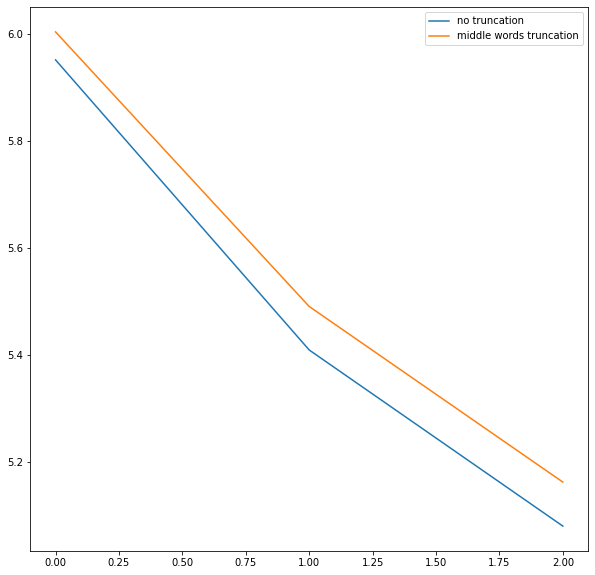

In [20]:
import matplotlib.pyplot as plt
import numpy as np


baseline_loss = np.load('outputs/losses_t5-small_epoch3.npy')
truncate_middle_loss = np.load('outputs_with_truncation/head+tail_losses_t5-small_epoch3.npy')
plt.figure(figsize=(10,10))
plt.plot(baseline_loss, label='no truncation')
plt.plot(truncate_middle_loss, label='middle words truncation')
plt.legend()
plt.show()

In [39]:
preds_normal = pd.read_csv('outputs/predictions_t5-small_epoch2.csv')
preds_normal

,Unnamed: 0,Generated Text,Actual Text
0,0,ex-Reading defender denies fraudulent trading ...,Middlesex batsman Adam Voges will be out until...
1,1,defending county champions Middlesex are sixth...,The Duchess of Cambridge will feature on the c...
2,2,the duchess is seen looking relaxed and wearin...,Google has hired the creator of one of the web...
3,3,Chris Poole stepped down as administrator of 4...,Two teenagers have been charged in connection ...
4,4,four police officers were injured in the incid...,A pedestrian has been struck by a taxi in Dund...
...,...,...,...
994,994,team from Swansea university used recycled mat...,The family of a teenager who lost his arms and...
995,995,the family claimed disability living allowance...,A Kenyan man accused of chopping off his wife'...
996,996,a video of her with stitches on her head and s...,"The RHI scandal continues to make headlines, b..."
997,997,the Belfast Telegraph and News Letter both car...,League One side Walsall have made their second...


In [38]:
preds_normal = pd.read_csv('outputs/predictions_t5-small_epoch2.csv')
preds_truncated = pd.read_csv('outputs_with_truncation/head+tail_predictions_t5-small_epoch2.csv')

preds_normal_np = np.asarray(preds_normal)
preds_truncated_np = np.asarray(preds_truncated)

for i in range(5):
    print("-----Generated Baseline-----\n", preds_np[i][1])
    print("-----Generated (Truncated)-----\n", preds_truncated_np[i][1])
    print("-----Actual-----\n", preds_np[i][2])    
    print('\n')

-----Generated Baseline-----
 all four denied fraudulent trading charges relating to the Sodje Sports Foundation. charge relates to offences which allegedly took place between 2008 and 2014.
-----Generated (Truncated)-----
 ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation. they were all released on bail and are due to stand trial in July.
-----Actual-----
 Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.


-----Generated Baseline-----
 Voges forced to retire hurt on 86 after suffering injury while batting in county championship draw with Somerset on 4 June. the 37- first-class games this season at an average of 57.50.
-----Generated (Truncated)-----
 Defending county champions Middlesex are sixth in the division one table. Voges retired from international cricket in February with a Test batting average of 61.87 from 31 innings.
-----Actual-----
 The Duchess of Cambridge will feature o

In [22]:
predsdf = pd.read_csv('outputs_with_truncation/head+tail_predictions_t5-small_epoch3.csv')

preds_np = np.asarray(predsdf)


for i in range(5):
    print("-----Generated-----\n", preds_np[i][1])
    print("-----Actual-----\n", preds_np[i][2])    
    print('\n')

-----Generated-----
 all four denied fraudulent trading charges relating to the Sodje Sports Foundation. charge relates to offences which allegedly took place between 2008 and 2014.
-----Actual-----
 Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.


-----Generated-----
 Voges forced to retire hurt on 86 after suffering injury while batting in county championship draw with Somerset on 4 June. the 37- first-class games this season at an average of 57.50.
-----Actual-----
 The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.


-----Generated-----
 the duchess is seen looking relaxed and wearing casual clothes. the shoot was in collaboration with the National Portrait Gallery.
-----Actual-----
 Google has hired the creator of one of the web's most notorious forums - 4chan.


-----Generated-----
 the site was widely credited as being the first place where leaked images of nude celebri

<hr>

<a id="4"></a>

## Draft Experiments (Random stuff)

In [23]:
### Experiment

sentences = [
    'In Japan, there is no lake bigger than Lake Biwa.',
'Tom\'s apartment is way too big for just one man.',
'Did you hear about the new animal discovered in Ecuador?',
]

tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=10)
print(encoded_input['input_ids'][0])

[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]


In [24]:
decoded = tokenizer.decode(tokenizer(sentences, padding=True, 
                                      truncation=True, max_length=8)['input_ids'][0])
print(decoded)

In Japan, there is no lake</s>


In [25]:
print("Before=", encoded_input)

Before= {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1], [3059, 31, 7, 4579, 19, 194, 396, 600, 21, 1], [3963, 25, 1616, 81, 8, 126, 2586, 3883, 16, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [26]:
test = [i for i in range(0,50)]
left = int(.4 * len(test))
right = int(.4 * len(test))

left_selection = test[:left]
right_selection = test[-right:]
all_indices = left_selection + right_selection
print(right_selection)

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [27]:
from transformers import tokenization_utils_base

newdict = {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]]}
new_encoding = tokenization_utils_base.BatchEncoding(newdict)

print(new_encoding)

{'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]]}


In [28]:
a = encoded_input.input_ids[0][0:3]
print(type(a))
a = torch.Tensor(a)
print(type(a))
# after = torch.Tensor([a]) # expected error here

#fix:
a = a.tolist()
after=torch.Tensor([a])



print(after)
after = torch.Tensor([encoded_input.input_ids[0][0:3]])
print(after)
print(type(after))
encoded_input['intput_ids'] = after
print("After:", encoded_input)

<class 'list'>
<class 'torch.Tensor'>
tensor([[  86., 3411.,    6.]])
tensor([[  86., 3411.,    6.]])
<class 'torch.Tensor'>
After: {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1], [3059, 31, 7, 4579, 19, 194, 396, 600, 21, 1], [3963, 25, 1616, 81, 8, 126, 2586, 3883, 16, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'intput_ids': tensor([[  86., 3411.,    6.]])}


### Encoding test

In [29]:
sentence_to_test = 'A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel. As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames. One of the tour groups is from Germany, the other from China and Taiwan. It was their first night in Northern Ireland. The driver of one of the buses said many of the passengers had left personal belongings on board and these had been destroyed. Both groups have organised replacement coaches and will begin their tour of the north coast later than they had planned. Police have appealed for information about the attack. Insp David Gibson said: It appears as though the fire started under one of the buses before spreading to the second. While the exact cause is still under investigation, it is thought that the fire was started deliberately.'

In [30]:
tokenizer2 = T5Tokenizer.from_pretrained(model_params["MODEL"])
source = tokenizer2(sentence_to_test, padding=True, truncation=True, max_length=512)

print(source)

{'input_ids': [71, 1472, 6196, 877, 326, 44, 8, 9108, 86, 29, 16, 6000, 1887, 44, 81, 11484, 10, 1755, 272, 4209, 30, 1856, 11, 2554, 130, 1380, 12, 1175, 8, 1595, 5, 282, 79, 3, 9094, 1067, 79, 1509, 8, 192, 14264, 6, 3, 16669, 596, 18, 969, 18, 1583, 16, 8, 443, 2447, 6, 3, 35, 6106, 19565, 57, 12314, 7, 5, 555, 13, 8, 1552, 1637, 19, 45, 3434, 6, 8, 119, 45, 1473, 11, 14441, 5, 94, 47, 70, 166, 706, 16, 5961, 5316, 5, 37, 2535, 13, 80, 13, 8, 14264, 243, 186, 13, 8, 9234, 141, 646, 525, 12770, 7, 30, 1476, 11, 175, 141, 118, 10932, 5, 2867, 1637, 43, 13666, 3709, 11210, 11, 56, 1731, 70, 1552, 13, 8, 3457, 4939, 865, 145, 79, 141, 4355, 5, 5076, 43, 3958, 15, 26, 21, 251, 81, 8, 3211, 5, 86, 7, 102, 1955, 24723, 243, 10, 94, 3475, 38, 713, 8, 1472, 708, 365, 80, 13, 8, 14264, 274, 16436, 12, 8, 511, 5, 818, 8, 2883, 1137, 19, 341, 365, 4962, 6, 34, 19, 816, 24, 8, 1472, 47, 708, 24067, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [37]:
print(source.input_ids)

[71, 1472, 6196, 877, 326, 44, 8, 9108, 86, 29, 16, 6000, 1887, 44, 81, 11484, 10, 1755, 272, 4209, 30, 1856, 11, 2554, 130, 1380, 12, 1175, 8, 1595, 5, 282, 79, 3, 9094, 1067, 79, 1509, 8, 192, 14264, 6, 3, 16669, 596, 18, 969, 18, 1583, 16, 8, 443, 2447, 6, 3, 35, 6106, 19565, 57, 12314, 7, 5, 555, 13, 8, 1552, 1637, 19, 45, 3434, 6, 8, 119, 45, 1473, 11, 14441, 5, 94, 47, 70, 166, 706, 16, 5961, 5316, 5, 37, 2535, 13, 80, 13, 8, 14264, 243, 186, 13, 8, 9234, 141, 646, 525, 12770, 7, 30, 1476, 11, 175, 141, 118, 10932, 5, 2867, 1637, 43, 13666, 3709, 11210, 11, 56, 1731, 70, 1552, 13, 8, 3457, 4939, 865, 145, 79, 141, 4355, 5, 5076, 43, 3958, 15, 26, 21, 251, 81, 8, 3211, 5, 86, 7, 102, 1955, 24723, 243, 10, 94, 3475, 38, 713, 8, 1472, 708, 365, 80, 13, 8, 14264, 274, 16436, 12, 8, 511, 5, 818, 8, 2883, 1137, 19, 341, 365, 4962, 6, 34, 19, 816, 24, 8, 1472, 47, 708, 24067, 5, 1]


In [32]:
no_real_tokens = sum(x != 0 for x in source.input_ids)

no_tokens = 50
left_remove_percent = .25

left = int(left_remove_percent * no_real_tokens)

left_selection_ids = torch.Tensor(source.input_ids[:left])
right_selection_ids = torch.Tensor(source.input_ids[left+no_tokens:len(source.input_ids)])
        
left_attention_mask = torch.Tensor(source.attention_mask[:left])
right_attention_mask = torch.Tensor(source.attention_mask[left+no_tokens:len(source.input_ids)])
        

new_ids = torch.concat([left_selection_ids, right_selection_ids], 0)        
new_masks = torch.concat([left_attention_mask,right_attention_mask], 0)
        
new_ids = new_ids.tolist()
new_masks = new_masks.tolist()

new_encoding = {
    'input_ids': torch.Tensor([new_ids]),
    'attention_mask': torch.Tensor([new_masks])
}

new_source = tokenization_utils_base.BatchEncoding(new_encoding)

print("Previous length: ", len(source.input_ids))
print("After: ", len(new_source['input_ids'][0]))
# print(new_source)

Previous length:  189
After:  139
